<a href="https://colab.research.google.com/github/maxant38/Taxi_NY_Analysis/blob/main/Maxence_Big_data_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import des librairies**

In [2]:
import os
import time
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numpy import argmax
from numpy import sqrt 

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_curve, accuracy_score, f1_score, precision_score, recall_score,confusion_matrix,roc_auc_score

seed = 1234


# **Import des données**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
# Maxence path
root_path_maxence = "gdrive/MyDrive/Cours mines/Projet Big Data Taxi NY" #ajoutez  un root_path qui mène au dossier partager

df_yellow_taxi = pd.read_parquet(root_path_maxence +"/yellow_tripdata_2022-01.parquet")
#df_green_taxi = pd.read_parquet(root_path_maxence +"/green_tripdata_2022-01.parquet")
#df_for_hire_taxi = pd.read_parquet(root_path_maxence +"/fhv_tripdata_2022-01.parquet")
#df_high_volume_taxi = pd.read_parquet(root_path_maxence +"/fhv_tripdata_2022-01.parquet")

In [5]:
df_yellow_taxi = pd.read_parquet(root_path_maxence +"/green_tripdata_2022-01.parquet")

Détail des colonnes:

<br>VendorID: a code indicating the provider associated with the trip record.
<br>tpep_pickup_datetime: the date and time when the trip began.
<br>tpep_dropoff_datetime: the date and time when the trip ended.
<br>passenger_count: the number of passengers in the vehicle.
<br>trip_distance: the distance of the trip, in miles.
<br>RatecodeID: the rate code associated with the trip.
<br>store_and_fwd_flag: a flag indicating whether the trip record was held in <br>vehicle memory before sending to the vendor.
<br>PULocationID: the ID of the location where the trip began.
<br>DOLocationID: the ID of the location where the trip ended.
<br>payment_type: the payment type used for the trip.
<br>fare_amount: the fare amount charged to the passenger.
<br>extra: any additional charges.
<br>mta_tax: the MTA tax charged on the trip.
<br>tip_amount: the amount of the tip given by the passenger.
<br>tolls_amount: the amount paid for tolls.
<br>improvement_surcharge: the improvement surcharge applied to the trip.
<br>total_amount: the total amount paid by the passenger.
<br>congestion_surcharge: the congestion surcharge applied to the trip (effective from 2021).
<br>airport_fee: the airport fee applied to the trip (if applicable).




In [9]:
df_high_volume_taxi

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2022-01-01 00:31:00,2022-01-01 01:05:00,NaN,NaN,None,B00009
1,B00009,2022-01-01 00:37:00,2022-01-01 01:05:00,NaN,NaN,None,B00009
2,B00037,2022-01-01 00:56:37,2022-01-01 01:06:11,NaN,85.0,None,B00037
3,B00037,2022-01-01 00:19:54,2022-01-01 00:30:47,NaN,85.0,None,B00037
4,B00037,2022-01-01 00:41:49,2022-01-01 00:52:16,NaN,188.0,None,B00037
...,...,...,...,...,...,...,...
1143686,B03380,2022-01-31 23:22:41,2022-01-31 23:26:39,234.0,107.0,None,B03380
1143687,B03380,2022-01-31 23:42:42,2022-01-31 23:52:58,114.0,148.0,None,B03380
1143688,B03380,2022-01-31 23:07:13,2022-01-31 23:13:40,90.0,113.0,None,B03380
1143689,B03380,2022-01-31 23:16:14,2022-01-31 23:31:03,113.0,140.0,None,B03380


In [5]:
df_yellow_taxi.shape

(2463931, 19)

#**Data Cleaning**

In [6]:
df_yellow_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
# Count the number of 0 values in each column
null_counts = df_yellow_taxi.isnull().sum() # This function takes a scalar or array-like object and indicates whether values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).
print(null_counts)

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71503
trip_distance                0
RatecodeID               71503
store_and_fwd_flag       71503
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71503
airport_fee              71503
dtype: int64


In [8]:
#On enleve les trajets ne contenant aucun passager
df_yellow_taxi[df_yellow_taxi['passenger_count'].isnull()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2392428,2,2022-01-01 00:50:00,2022-01-01 00:54:00,NaN,1.00,NaN,None,68,246,0,13.20,0.0,0.5,1.75,0.0,0.3,18.25,NaN,NaN
2392429,2,2022-01-01 00:49:24,2022-01-01 01:27:36,NaN,13.31,NaN,None,257,223,0,44.87,0.0,0.5,10.05,0.0,0.3,55.72,NaN,NaN
2392430,2,2022-01-01 00:42:00,2022-01-01 00:56:00,NaN,2.87,NaN,None,143,236,0,13.23,0.0,0.5,3.51,0.0,0.3,20.04,NaN,NaN
2392431,2,2022-01-01 00:40:00,2022-01-01 00:55:00,NaN,3.24,NaN,None,143,262,0,14.19,0.0,0.5,3.72,0.0,0.3,21.21,NaN,NaN
2392432,2,2022-01-01 00:40:00,2022-01-01 00:52:00,NaN,2.19,NaN,None,239,166,0,13.20,0.0,0.5,5.25,0.0,0.3,21.75,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [9]:
df_yellow_taxi  = df_yellow_taxi.dropna(subset=['passenger_count'])

In [10]:
# Count the number of 0 values in each column
null_counts = df_yellow_taxi.isnull().sum() # This function takes a scalar or array-like object and indicates whether values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).
print(null_counts)

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64


On n'a plus aucune valeur null/NA dans les autres colonnes

In [11]:
# Compte le nombre de dupplicated raws
duplicate_rows = df_yellow_taxi[df_yellow_taxi.duplicated()]
num_duplicates = len(duplicate_rows)
print(num_duplicates)
#aucune

0


In [12]:
#ajout d'une variable temps de trajet
df_yellow_taxi['trip_duration'] = (df_yellow_taxi['tpep_dropoff_datetime'] - df_yellow_taxi['tpep_pickup_datetime']).dt.total_seconds()

In [13]:
# Reset the index
df_yellow_taxi = df_yellow_taxi.reset_index(drop=True)
df_yellow_taxi

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,1069.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,504.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,538.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,602.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,2252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392423,1,2022-01-31 23:24:28,2022-01-31 23:32:47,1.0,1.50,1.0,N,163,143,2,7.5,3.0,0.5,0.00,0.0,0.3,11.30,2.5,0.0,499.0
2392424,2,2022-01-31 23:17:44,2022-01-31 23:22:05,1.0,1.02,1.0,N,249,68,1,5.5,0.5,0.5,1.86,0.0,0.3,11.16,2.5,0.0,261.0
2392425,2,2022-01-31 23:26:41,2022-01-31 23:34:54,1.0,1.53,1.0,N,68,90,1,8.0,0.5,0.5,2.95,0.0,0.3,14.75,2.5,0.0,493.0
2392426,2,2022-01-31 23:37:41,2022-01-31 23:45:26,1.0,1.59,1.0,N,90,79,1,7.5,0.5,0.5,2.26,0.0,0.3,13.56,2.5,0.0,465.0


In [14]:
df_yellow_taxi

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,1069.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,504.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,538.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,602.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,2252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392423,1,2022-01-31 23:24:28,2022-01-31 23:32:47,1.0,1.50,1.0,N,163,143,2,7.5,3.0,0.5,0.00,0.0,0.3,11.30,2.5,0.0,499.0
2392424,2,2022-01-31 23:17:44,2022-01-31 23:22:05,1.0,1.02,1.0,N,249,68,1,5.5,0.5,0.5,1.86,0.0,0.3,11.16,2.5,0.0,261.0
2392425,2,2022-01-31 23:26:41,2022-01-31 23:34:54,1.0,1.53,1.0,N,68,90,1,8.0,0.5,0.5,2.95,0.0,0.3,14.75,2.5,0.0,493.0
2392426,2,2022-01-31 23:37:41,2022-01-31 23:45:26,1.0,1.59,1.0,N,90,79,1,7.5,0.5,0.5,2.26,0.0,0.3,13.56,2.5,0.0,465.0


# **Prédiction**

In [15]:
df_yellow_taxi

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,1069.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,504.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,538.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,602.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,2252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392423,1,2022-01-31 23:24:28,2022-01-31 23:32:47,1.0,1.50,1.0,N,163,143,2,7.5,3.0,0.5,0.00,0.0,0.3,11.30,2.5,0.0,499.0
2392424,2,2022-01-31 23:17:44,2022-01-31 23:22:05,1.0,1.02,1.0,N,249,68,1,5.5,0.5,0.5,1.86,0.0,0.3,11.16,2.5,0.0,261.0
2392425,2,2022-01-31 23:26:41,2022-01-31 23:34:54,1.0,1.53,1.0,N,68,90,1,8.0,0.5,0.5,2.95,0.0,0.3,14.75,2.5,0.0,493.0
2392426,2,2022-01-31 23:37:41,2022-01-31 23:45:26,1.0,1.59,1.0,N,90,79,1,7.5,0.5,0.5,2.26,0.0,0.3,13.56,2.5,0.0,465.0


## Corrélation entre les variables

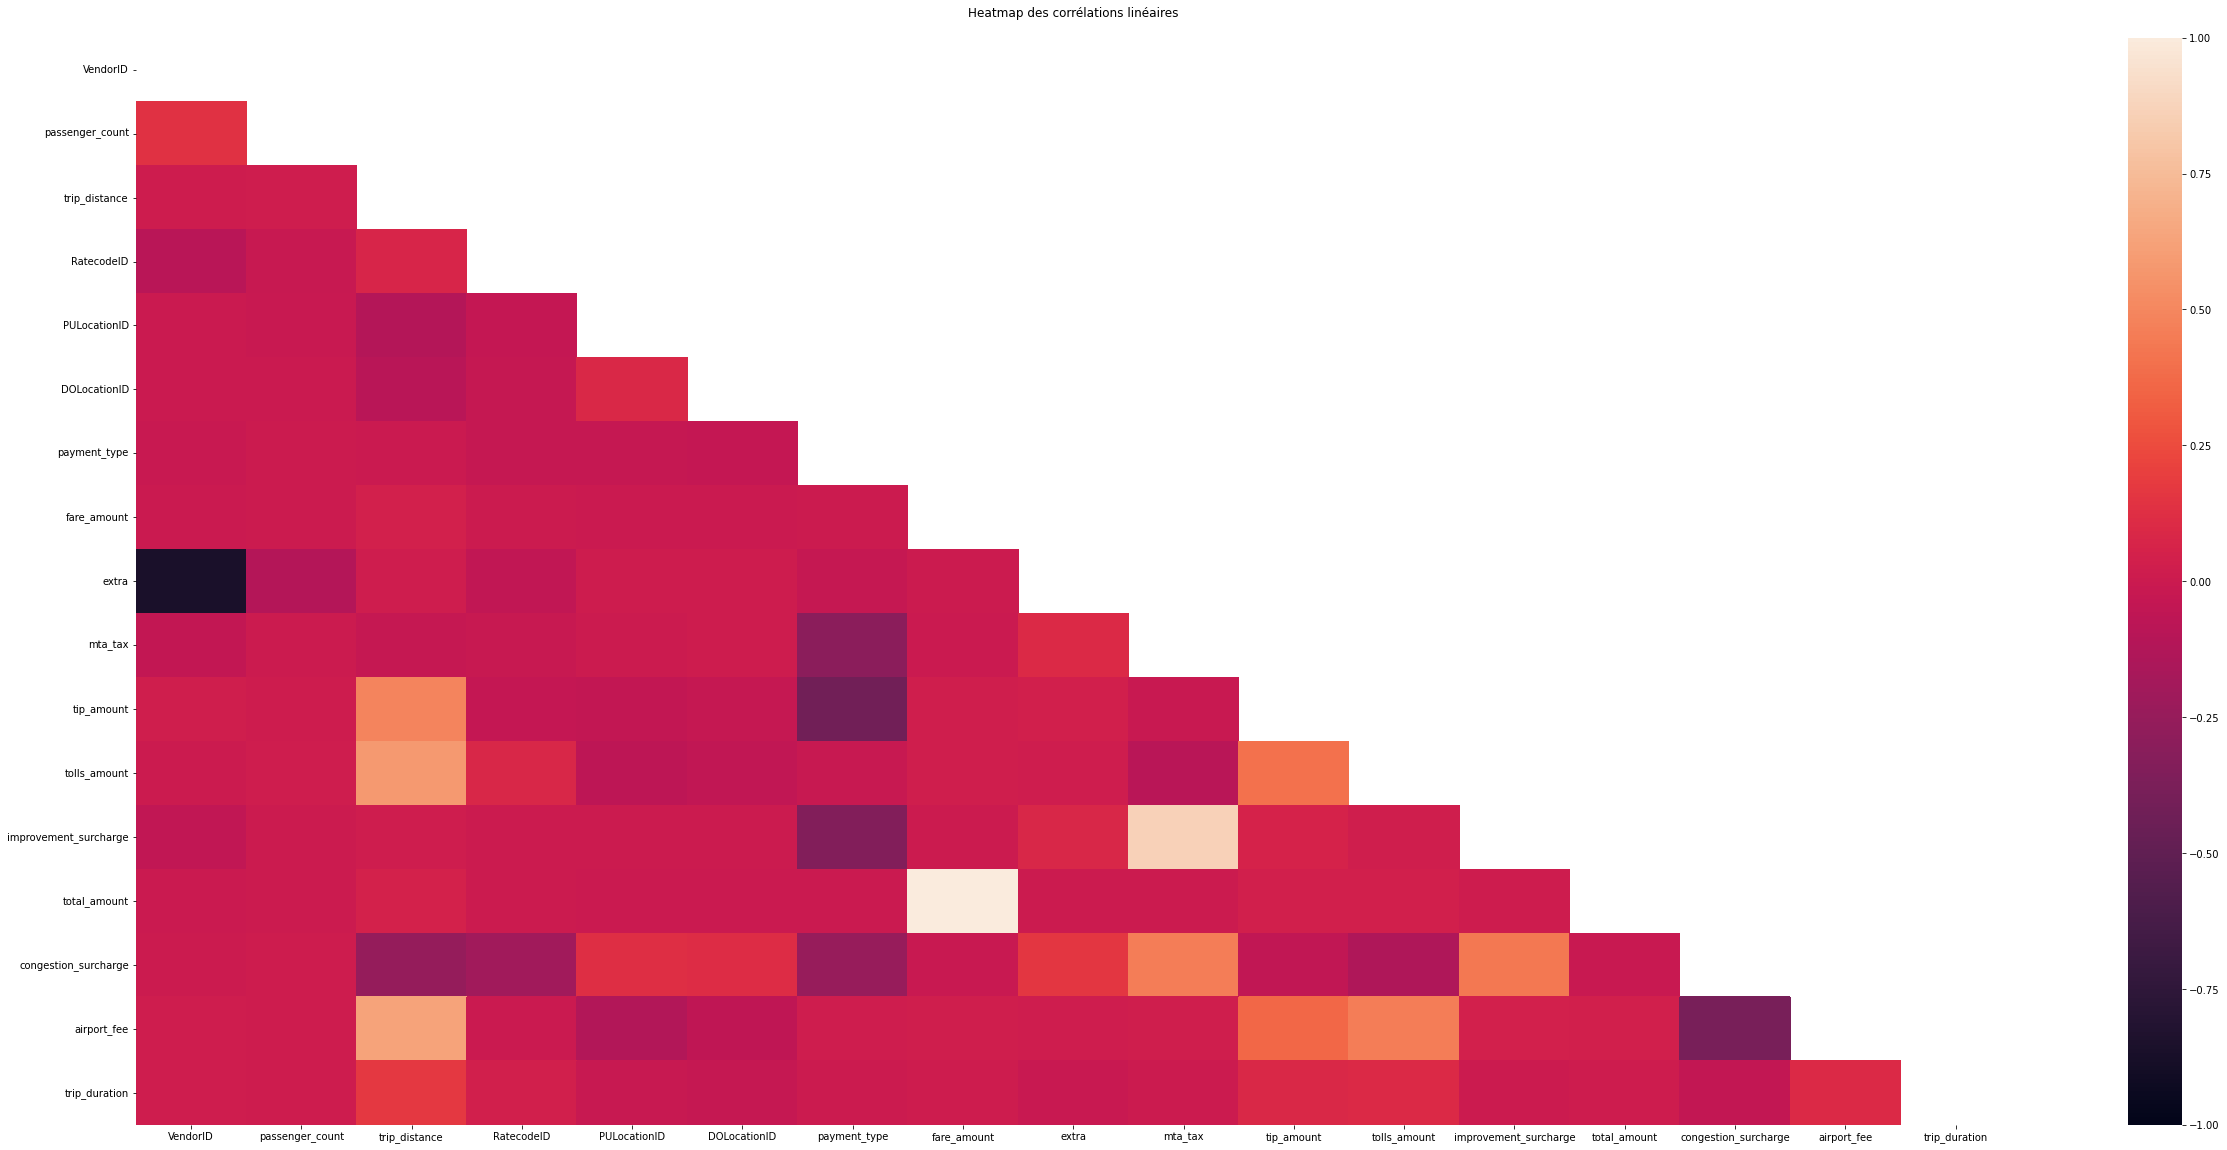

In [ ]:
corr = df_yellow_taxi.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(42,20))
ax = sns.heatmap(corr,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask
                )
plt.title(f"Heatmap des corrélations linéaires\n"
          )
plt.show()

##Split Train/Test & Normalisation & Encoding


On enlève les variables suivants:
payment_type: the payment type used for the trip.  
fare_amount: the fare amount charged to the passenger.
extra: any additional charges.
mta_tax: the MTA tax charged on the trip.
tip_amount: the amount of the tip given by the passenger.
tolls_amount: the amount paid for tolls.
improvement_surcharge: the improvement surcharge applied to the trip.

congestion_surcharge: the congestion surcharge applied to the trip (effective from 2021).
airport_fee: the airport fee applied to the trip (if applicable).

In [17]:
#On convertit les données de date
df_yellow_taxi['tpep_dropoff_datetime']  =  pd.to_numeric(pd.to_datetime(df_yellow_taxi['tpep_dropoff_datetime']))
df_yellow_taxi['tpep_pickup_datetime']  =  pd.to_numeric(pd.to_datetime(df_yellow_taxi['tpep_pickup_datetime']))

In [18]:
# Get a list of categorical columns
cat_cols = df_yellow_taxi.select_dtypes(['category','object']).columns
print(cat_cols)

Index(['store_and_fwd_flag'], dtype='object')


In [19]:
#on encode
df_yellow_taxi = pd.get_dummies(df_yellow_taxi, columns=['store_and_fwd_flag','VendorID','RatecodeID','PULocationID','DOLocationID'])

In [20]:
#Pour ne pas crash il faut utiliser un subset
df_yellow_taxi_sample = df_yellow_taxi.sample(frac=0.01, replace=False, random_state=seed)

In [21]:
y = df_yellow_taxi_sample["total_amount"]
variables_to_remove = ['total_amount','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','airport_fee','congestion_surcharge','payment_type']
X = df_yellow_taxi_sample.drop(columns=variables_to_remove, axis=1)

In [22]:

X_train, X_test, y_train, y_test=train_test_split(X,
    y,test_size=0.2,
    shuffle=True,                                       
    random_state=seed)

In [23]:

#classe pour standardisation
from sklearn.preprocessing import StandardScaler
#instanciation
sc = StandardScaler()


In [24]:
#transformation – centrage-réduction

X_train= sc.fit_transform(X_train)



In [25]:
# La libraire Sklearn réalise une normalisation biaisé
X_test= sc.fit_transform(X_test)


# Predictions

## Creation des metrics

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

def evaluation(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return mae, mse, rmse, r_squared

## Moyenne

In [28]:
import pandas as pd

def mean_df(df: pd.DataFrame) -> pd.Series:
    return df.select_dtypes(include=[np.number]).mean()


In [32]:
import pandas as pd

predictions = pd.DataFrame(data = [19.05]*4785, columns=["value"])


In [30]:
y_train.mean()

19.05460943622969

In [33]:
mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)

MAE: 9.173763845350052
MSE: 240.4667375966562
RMSE: 15.50698995926212
R2 Score: -9.280389223342844e-05
------------------------------


## Regression Lineaire

In [ ]:
from sklearn.linear_model import LinearRegression

results = []

reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
predictions = reg_lin.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)


new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared}
results.append(new_row)

MAE: 4924758564026.04
MSE: 6.87506579962285e+27
RMSE: 82916016544590.77
R2 Score: -2.8593159707690174e+25
------------------------------


## Regression Ridge

In [ ]:
from sklearn.linear_model import Ridge
reg_ridge = Ridge()
reg_ridge.fit(X_train, y_train)
predictions = reg_ridge.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)


new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared}
results.append(new_row)

MAE: 2.8304432184738784
MSE: 52.27048439629525
RMSE: 7.229832943871888
R2 Score: 0.7826088721327458
------------------------------


## Regression Lasso

In [ ]:
from sklearn.linear_model import Lasso
reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)
predictions = reg_lasso.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)


new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared}
results.append(new_row)

MAE: 3.0746181137792026
MSE: 59.959848983410836
RMSE: 7.743374521706336
R2 Score: 0.7506290720700156
------------------------------


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(n_estimators=100)
reg_rf.fit(X_train, y_train)
predictions = reg_rf.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)


new_row = {"Model": "RandomForest","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared}
results.append(new_row)


MAE: 2.1977198676419376
MSE: 38.60539336860026
RMSE: 6.213323858338648
R2 Score: 0.8394415107667559


## XGBoost

In [ ]:
from xgboost import XGBRegressor
reg_xgb = XGBRegressor(n_estimators=1500, learning_rate=0.02)
reg_xgb.fit(X_train, y_train)
predictions = reg_xgb.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)


new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared}
results.append(new_row)

[21:44:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 2.3438480561629107
MSE: 43.11497691299737
RMSE: 6.566199579132314
R2 Score: 0.820686309542763
------------------------------


# Comparaison Models

In [ ]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score"])
for row in results:
    models = models.append(row, ignore_index=True)

In [ ]:

df_comparaison  = models.sort_values(by="RMSE")

In [ ]:
df_comparaison

,Model,MAE,MSE,RMSE,R2 Score
3,RandomForest,2.197720e+00,3.860539e+01,6.213324e+00,8.394415e-01
4,XGBRegressor,2.343848e+00,4.311498e+01,6.566200e+00,8.206863e-01
1,Ridge,2.830443e+00,5.227048e+01,7.229833e+00,7.826089e-01
2,Lasso,3.074618e+00,5.995985e+01,7.743375e+00,7.506291e-01
0,LinearRegression,4.924759e+12,6.875066e+27,8.291602e+13,-2.859316e+25


In [ ]:
df_comparaison  = df_comparaison[df_comparaison.Model != 'LinearRegression']

In [ ]:
df_comparaison

,Model,MAE,MSE,RMSE,R2 Score
3,RandomForest,2.197720,38.605393,6.213324,0.839442
4,XGBRegressor,2.343848,43.114977,6.566200,0.820686
1,Ridge,2.830443,52.270484,7.229833,0.782609
2,Lasso,3.074618,59.959849,7.743375,0.750629


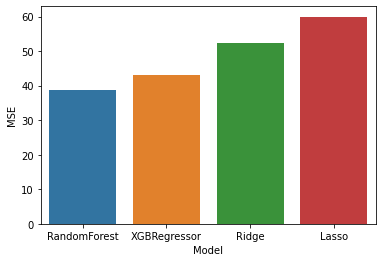

In [ ]:

# create bar chart
sns.barplot(x='Model', y='MSE', data=df_comparaison)
plt.show()

## Explication modèle XGBoost

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
features_display =  list(X)

In [ ]:
import shap
explainer = shap.TreeExplainer(reg_xgb)
shap_values = explainer.shap_values(X_test)

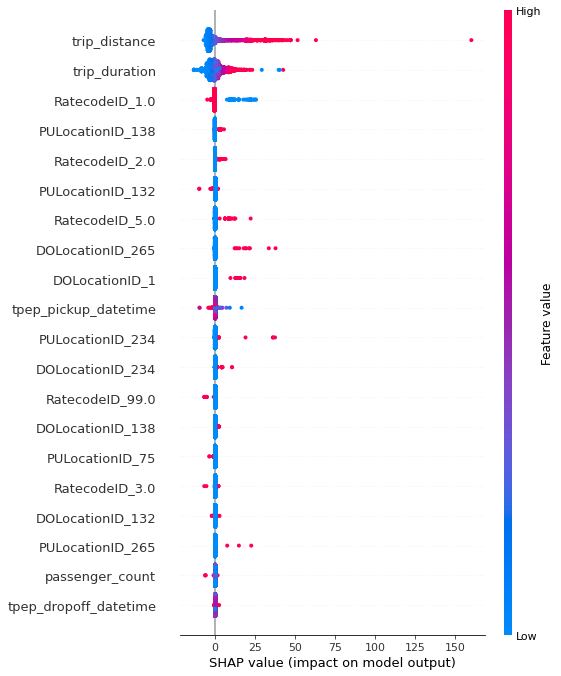

In [ ]:
plt.grid(False) 
shap.summary_plot(shap_values, X_test,features_display)

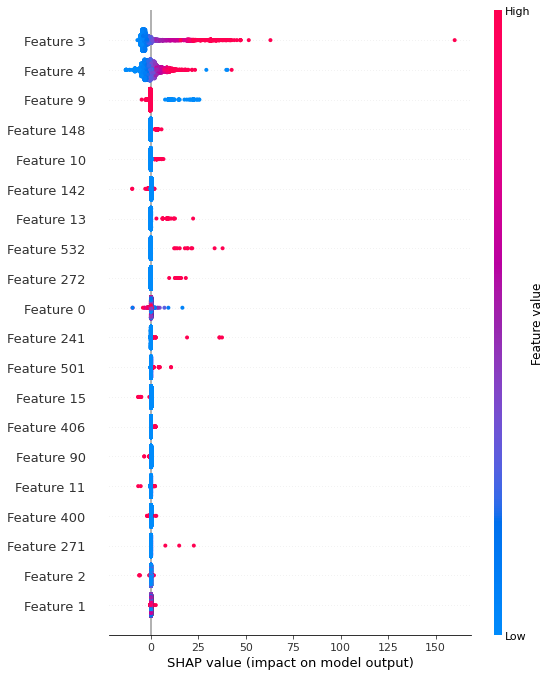

In [ ]:
plt.grid(False) 
shap.summary_plot(shap_values, X_test)

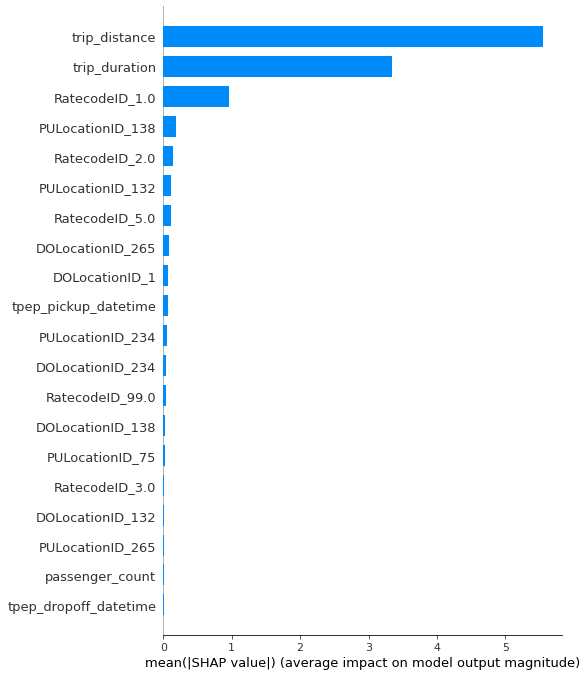

In [ ]:
shap.summary_plot(shap_values, X_test, features_display,plot_type="bar")

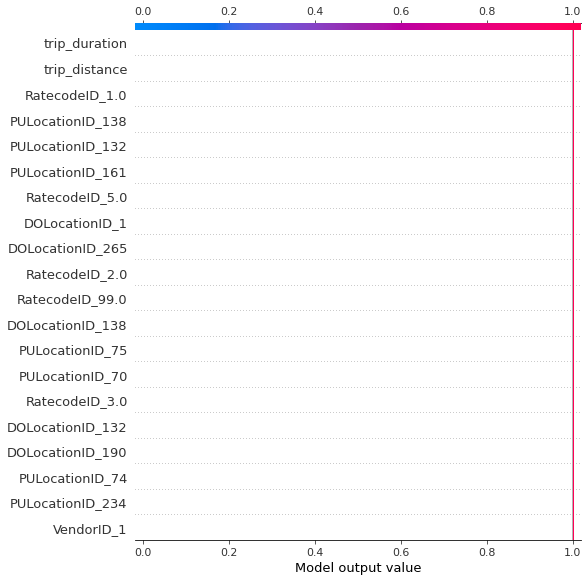

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[0], features_display,link='logit')

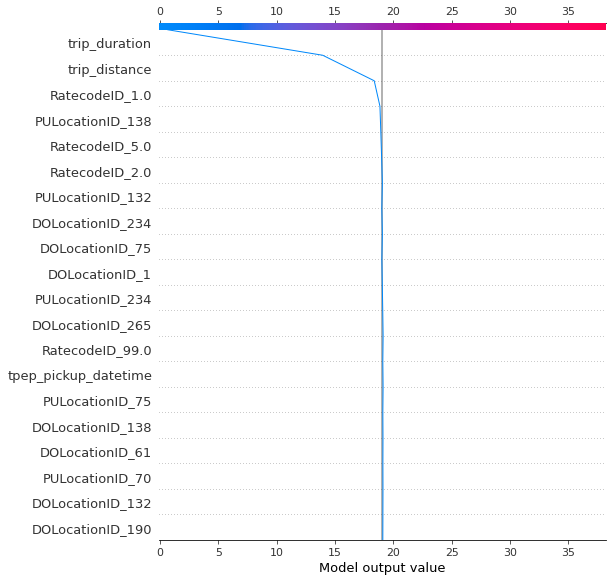

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[1], features_display)

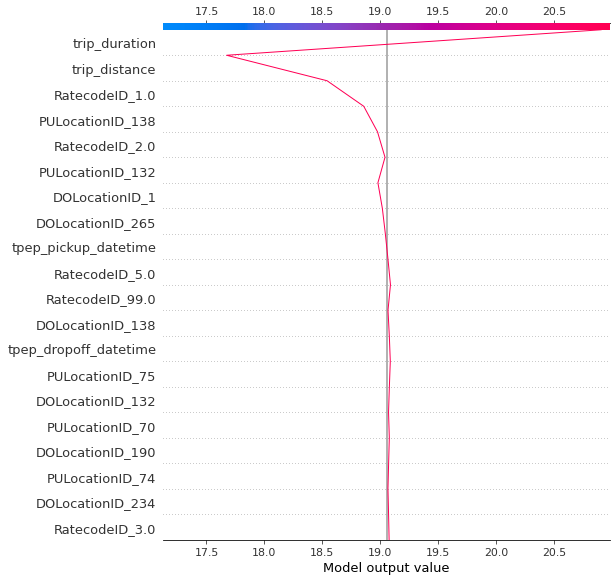

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[120], features_display)

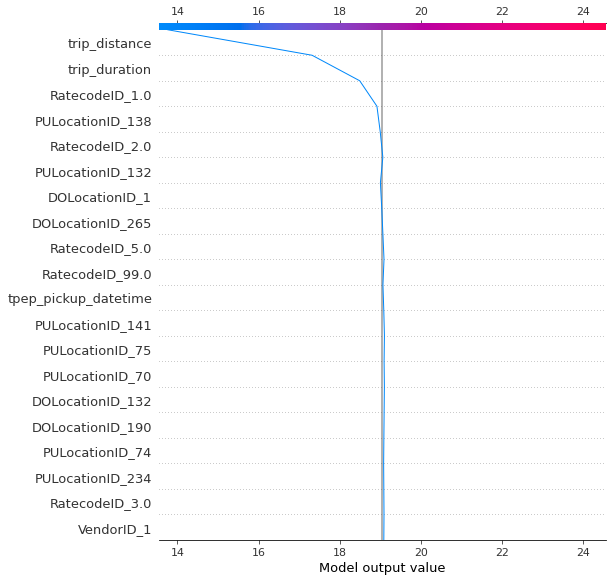

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[124
], features_display)

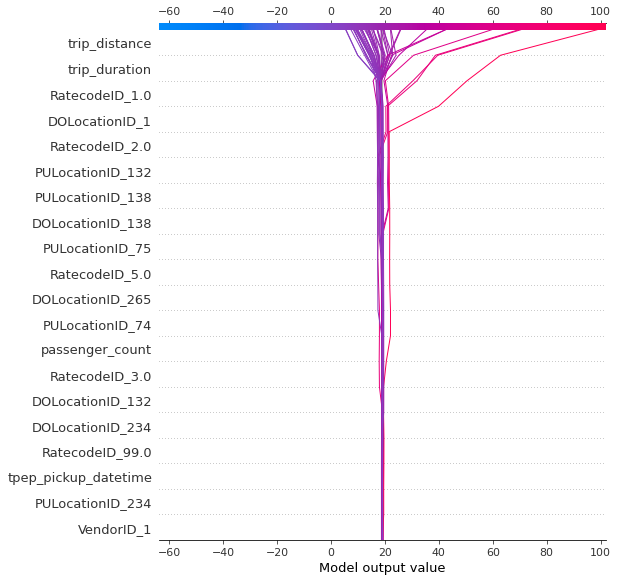

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[27:78], features_display,)

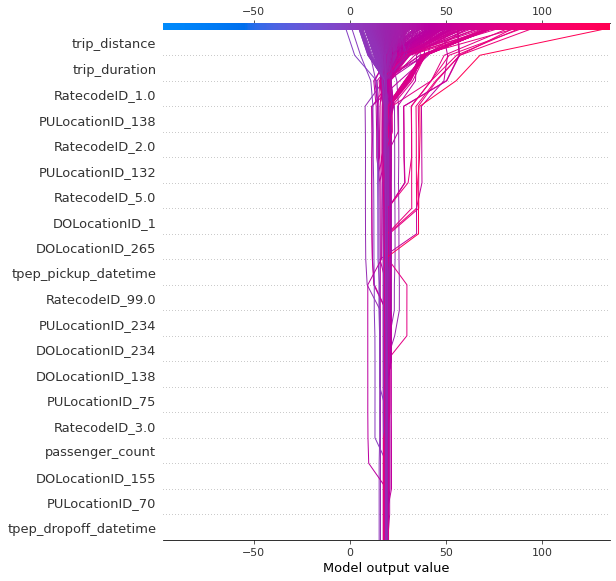

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[1000:2000], features_display,)

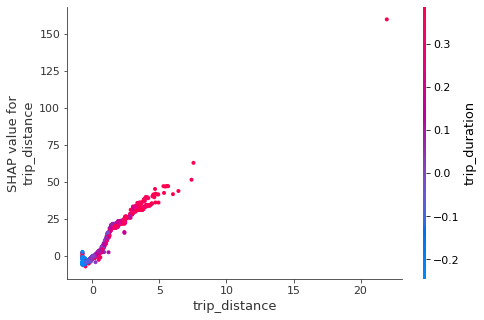

In [ ]:
shap.dependence_plot("trip_distance", shap_values, X_test, features_display)

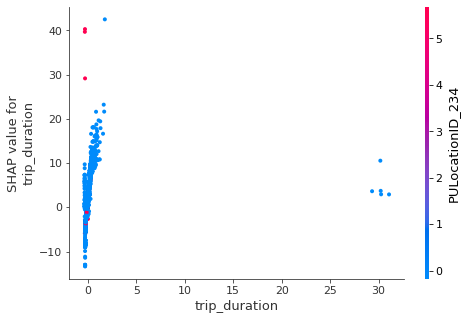

In [ ]:
shap.dependence_plot("trip_duration", shap_values, X_test, features_display)

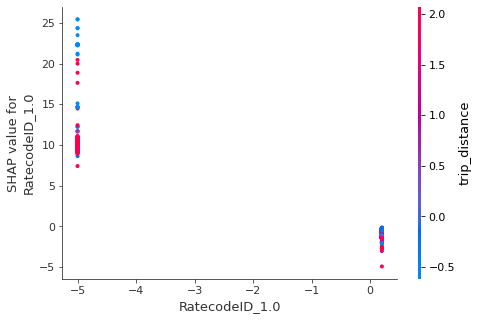

In [ ]:
shap.dependence_plot("RatecodeID_1.0", shap_values, X_test, features_display)

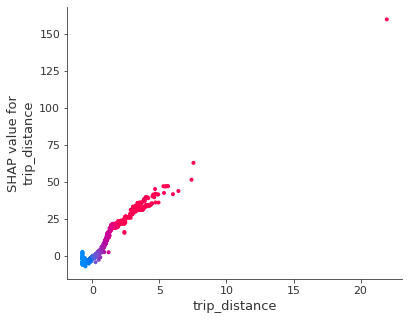

In [ ]:
shap.dependence_plot("trip_distance", shap_values, X_test,features_display,interaction_index="trip_distance")

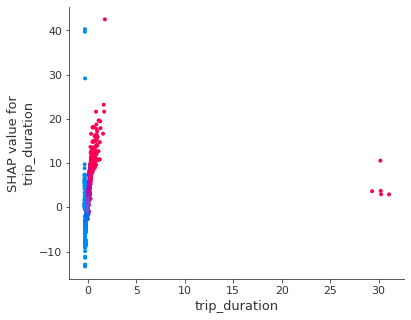

In [ ]:
shap.dependence_plot("trip_duration", shap_values, X_test,features_display,interaction_index="trip_duration")

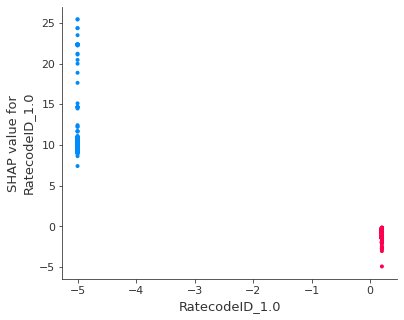

In [ ]:
shap.dependence_plot("RatecodeID_1.0", shap_values, X_test,features_display,interaction_index="RatecodeID_1.0")

## Analyse Flux de Taxi

In [ ]:
# Convertir les colonnes de date en objets datetime
df_yellow_taxi["tpep_pickup_datetime"] = pd.to_datetime(df_yellow_taxi["tpep_pickup_datetime"])
df_yellow_taxi["tpep_dropoff_datetime"] = pd.to_datetime(df_yellow_taxi["tpep_dropoff_datetime"])

# Extraire la date de prise en charge des trajets
df_yellow_taxi["pickup_date"] = df_yellow_taxi["tpep_pickup_datetime"].dt.date

# Compter le nombre de trajets par jour
daily_trip_count = df_yellow_taxi.groupby("pickup_date").size()

# Afficher le résultat
print(daily_trip_count)

In [ ]:
# Compter le nombre de trajets par secteur et par jour
daily_trip_count_by_sector = df_yellow_taxi.groupby(["PULocationID", "pickup_date"]).size()

# Afficher le résultat
print(daily_trip_count_by_sector)

In [ ]:
daily_trip_count_by_sector.plot(kind='bar')

# Ajouter des titres et des étiquettes à l'axe
plt.title("Nombre de trajets par secteur et par jour")
plt.xlabel("Secteur et date")
plt.ylabel("Nombre de trajets")

# Afficher le graphique
plt.show()

In [ ]:
# Appliquer un filtre pour sélectionner uniquement les trajets de certains secteurs
data = data[data["PULocationID"].isin([142,236,236])]

# Compter le nombre de trajets par secteur et par jour
daily_trip_count_by_sector = data.groupby(["PULocationID", "pickup_date"]).size()

# créer un bar chart des trajets par secteur et par jour
daily_trip_count_by_sector.plot(kind='bar')

# Ajouter des titres et des étiquettes à l'axe
plt.title("Nombre de trajets par secteur et par jour")
plt.xlabel("Secteur et date")
plt.ylabel("Nombre de trajets")

# Afficher le graphique
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Convertir les colonnes de date en objets datetime
df_yellow_taxi["tpep_pickup_datetime"] = pd.to_datetime(df_yellow_taxi["tpep_pickup_datetime"])
df_yellow_taxi["tpep_dropoff_datetime"] = pd.to_datetime(df_yellow_taxi["tpep_dropoff_datetime"])

# Extraire la date de prise en charge des trajets
df_yellow_taxi["pickup_date"] = df_yellow_taxi["tpep_pickup_datetime"].dt.date

# Appliquer un filtre pour sélectionner uniquement les trajets de certains secteurs
df_yellow_taxi = df_yellow_taxi[df_yellow_taxi["PULocationID"].isin([142,236,236])]

# Compter le nombre de trajets par secteur et par jour
daily_trip_count_by_sector = df_yellow_taxi.groupby(["PULocationID", "pickup_date"]).size()

# Ajout du nombre de taxi par jour
daily_taxi_count = df_yellow_taxi.groupby("pickup_date")["VendorID"].nunique()

# créer un bar chart des trajets par secteur et par jour
daily_trip_count_by_sector.plot(kind='bar', label='Nombre de trajets')

# Ajouter un graphique pour le nombre de taxis
daily_taxi_count.plot(kind='bar', label='Nombre de taxi', secondary_y=True)

# Ajouter des titres et des étiquettes à l'axe
plt.title("Nombre de trajets et de taxis par secteur et par jour")
plt.xlabel("Secteur et date")
plt.ylabel("Nombre de trajets")
plt.legend()
# Afficher le graphique
plt.show()
